## Import Necessary Functions

These are required to utilise functions specific for data analysis and visualisations.

In [11]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [12]:

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score



In [13]:
import pickle

# Load the training and testing split from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)


X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

Load the different splits

In [14]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

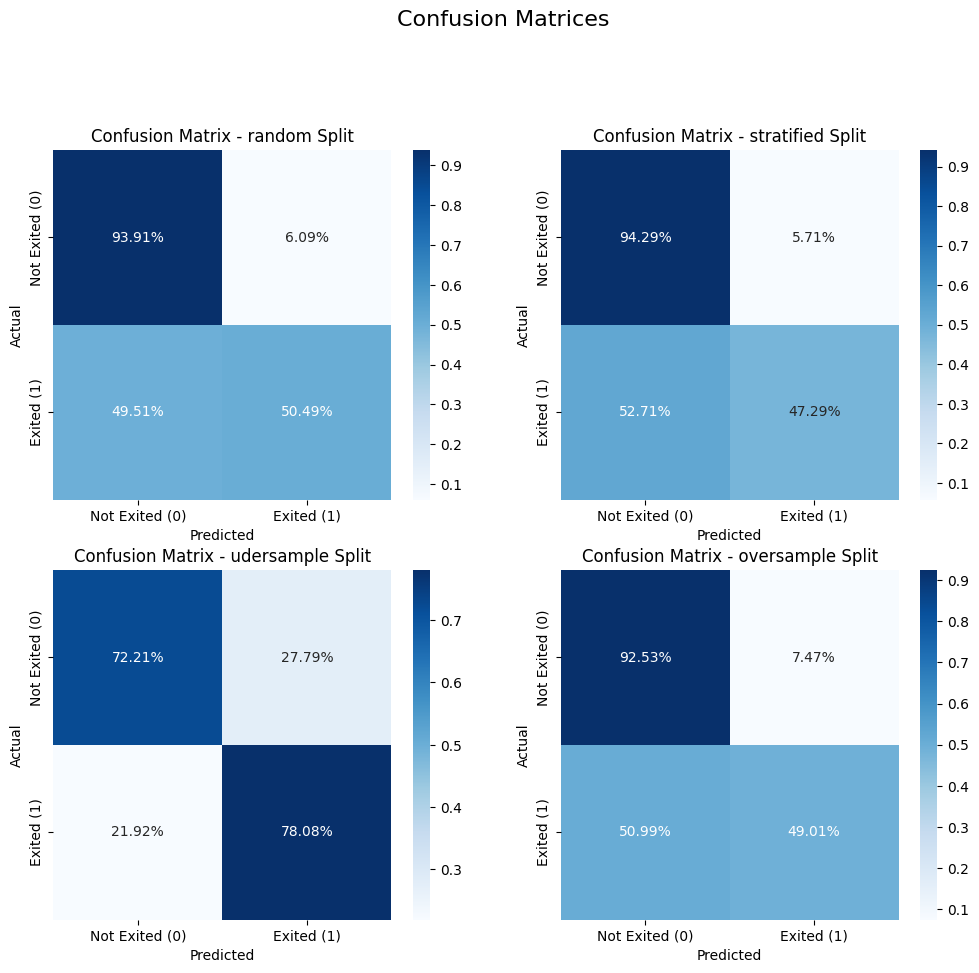

<Figure size 800x600 with 0 Axes>

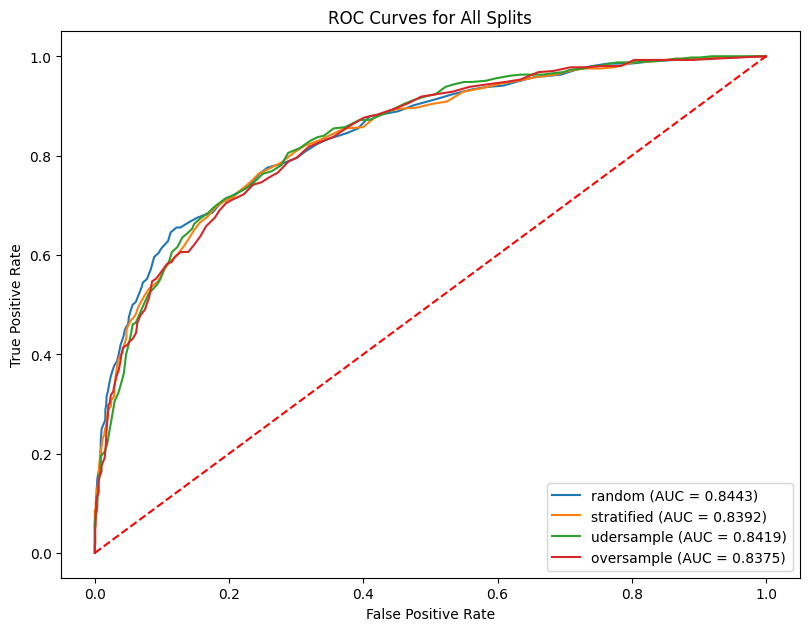

random - Validation Accuracy: 0.8519, Test Accuracy: 0.8510
random - Test Precision (Class 1): 0.6788
Test Recall (Class 1): 0.5049
Test F1-Score (Class 1): 0.5791
False Positives: 97, False Negatives: 201
stratified - Validation Accuracy: 0.8625, Test Accuracy: 0.8475
stratified - Test Precision (Class 1): 0.6784
Test Recall (Class 1): 0.4729
Test F1-Score (Class 1): 0.5573
False Positives: 91, False Negatives: 214
udersample - Validation Accuracy: 0.7806, Test Accuracy: 0.7340
udersample - Test Precision (Class 1): 0.4171
Test Recall (Class 1): 0.7808
Test F1-Score (Class 1): 0.5437
False Positives: 443, False Negatives: 89
oversample - Validation Accuracy: 0.8481, Test Accuracy: 0.8370
oversample - Test Precision (Class 1): 0.6258
Test Recall (Class 1): 0.4901
Test F1-Score (Class 1): 0.5497
False Positives: 119, False Negatives: 207


In [15]:
model = RandomForestClassifier(n_estimators = 100) #Can tune n_estimators or other hyperparameters

#Store our performance results in a dictionary
performance = {}


#Create a 2x2 grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
plt.figure(figsize=(8,6))

#ROC curve figure 
plt.figure(figsize=(8,6))


# Train and evaluate the model on each split
for idx, split in enumerate(split_data):

    # Define sets
    X_train, X_val, y_train, y_val = split_data[split]

    model.fit(X_train, y_train)

    #Predict on validation set (optional, you can validate performance on training)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Predict on the unseen test set
    y_test_pred = model.predict(X_test_raw)
    test_accuracy = accuracy_score(y_test_raw, y_test_pred)

    #Get classification report as a dictionary
    test_report = classification_report(y_test_raw, y_test_pred, output_dict=True)



    #Plot the confusion matrix for the teset set 
    conf_matrix = confusion_matrix(y_test_raw, y_test_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    #Extract precision, recall, and F1 score for class 1
    precision = test_report['1']['precision']
    recall = test_report['1']['recall']
    f1_score = test_report['1']['f1-score']


    #Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_test_raw, y_test_pred)


    #Normalize the confusion matrix by the number of true samples per class
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Exited (0)', 'Exited (1)'],
                yticklabels=['Not Exited (0)', 'Exited (1)'])
    axes[idx].set_title(f'Confusion Matrix - {split} Split')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')


    #Plot ROC curve on the same figure for all splits
    y_test_pred_prob = model.predict_proba(X_test_raw)[:, 1]  # Get predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test_raw, y_test_pred_prob)
    roc_auc = roc_auc_score(y_test_raw, y_test_pred_prob)
    plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')


    #Define performance metrics
    performance[split] = {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
         'test_precision_1': precision,
        'test_recall_1': recall,
        'test_f1_score_1': f1_score,
        'false_positives': fp,
        'false_negatives': fn,
        'balanced_accuracy': balanced_acc
    }


#Finish off confusion matrix
plt.tight_layout()
fig.suptitle('Confusion Matrices', y=1.02,fontsize = 16)


#Finish off ROC curves
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Splits')
plt.legend(loc='lower right')


#Show the plots
plt.show()  

# Output performance metrics
for split, perf in performance.items():
    print(f"{split} - Validation Accuracy: {perf['val_accuracy']:.4f}, Test Accuracy: {perf['test_accuracy']:.4f}")
    print(f"{split} - Test Precision (Class 1): {perf['test_precision_1']:.4f}")
    print(f"Test Recall (Class 1): {perf['test_recall_1']:.4f}")
    print(f"Test F1-Score (Class 1): {perf['test_f1_score_1']:.4f}")
    print(f"False Positives: {perf['false_positives']}, False Negatives: {perf['false_negatives']}")
    